In [2]:
import sklearn.datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mnist = sklearn.datasets.fetch_mldata('MNIST original')
X, Y = mnist['data'], np.array(mnist['target'], dtype='int')

ntrain = 60000
x_train, y_train = X[:ntrain], Y[:ntrain]
x_test, y_test = X[ntrain:], Y[ntrain:]

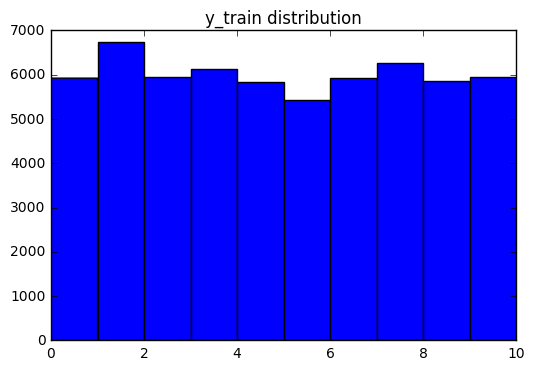

In [4]:
plt.hist(y_train, bins = range(11))
plt.title('y_train distribution')
plt.show()

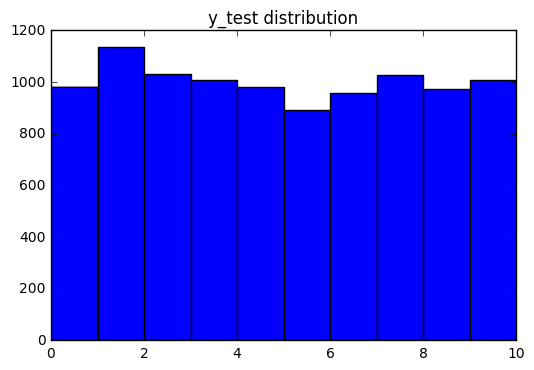

In [5]:
plt.hist(y_test, bins = range(11))
plt.title('y_test distribution')
plt.show()

Проведем процедуру выравнивания(уберем наклон) для всех цифр.

# Deskew text with OpenCV 

In [6]:
SZ = 28 # images are SZ x SZ grayscale

affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    img = img.reshape((SZ,SZ))
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img.reshape(784)

In [7]:
permutation = np.random.permutation(ntrain)
ntrain_small = 1000
x_train_small = x_train[permutation][:ntrain_small]
y_train_small = y_train[permutation][:ntrain_small]

In [8]:
x_train_deskew = [deskew(x) for x in x_train]
x_test_deskew = [deskew(x) for x in x_test]
x_train_small_deskew = [deskew(x) for x in x_train_small]

### Оригинальная цифра

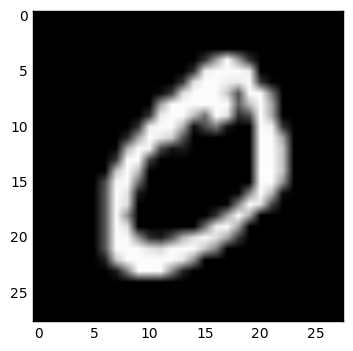

In [9]:
plt.imshow(np.array(x_train[0], dtype='uint8').reshape((28,28)), cmap='gray')

### Цифра после выравнивания

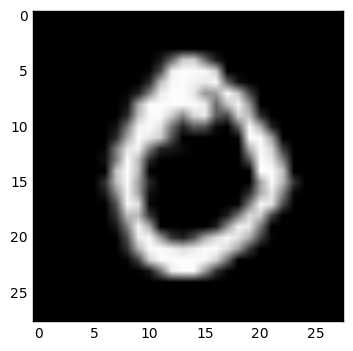

In [10]:
plt.imshow(np.array(x_train_deskew[0], dtype='uint8').reshape((28,28)), cmap='gray')

## Tunning SVM params

In [39]:
import sklearn.model_selection
import sklearn.svm

tuned_parameters = [
    {
        'kernel': ['rbf'], 
        'gamma': [0.5, 0.05],
        'C': [0.01, 0.1, 1]
    },
    {
        'kernel': ['poly'], 
        'degree': [2, 3, 4, 5]
    }
]


grid_search = sklearn.model_selection.GridSearchCV(
    sklearn.svm.SVC(),
    tuned_parameters,
    cv=5,
    n_jobs=32
)
grid_search.fit(x_train_small_deskew, y_train_small)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.115 (+/-0.003) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.5}
0.115 (+/-0.003) for {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.05}
0.115 (+/-0.003) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.5}
0.115 (+/-0.003) for {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.05}
0.115 (+/-0.003) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.5}
0.115 (+/-0.003) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.05}
0.919 (+/-0.047) for {'kernel': 'poly', 'degree': 2}
0.901 (+/-0.049) for {'kernel': 'poly', 'degree': 3}
0.874 (+/-0.052) for {'kernel': 'poly', 'degree': 4}
0.838 (+/-0.043) for {'kernel': 'poly', 'degree': 5}


## SVM with polynomial kernel deg = 4

In [34]:
import sklearn.svm
estimator = sklearn.svm.SVC(kernel = 'poly', degree = 4)
estimator.fit(x_train_deskew, y_train)
print('SVC score on deskew train:', estimator.score(x_train_deskew, y_train))
print('SVC score on deskew validation:', estimator.score(x_test_deskew, y_test))

('SVC score on deskew train:', 1.0)
('SVC score on deskew validation:', 0.98060000000000003)


## SVM with polynomial kernel deg = 3

In [35]:
estimator = sklearn.svm.SVC(kernel = 'poly', degree = 3)
estimator.fit(x_train_deskew, y_train)
print('SVC score on deskew train:', estimator.score(x_train_deskew, y_train))
print('SVC score on deskew validation:', estimator.score(x_test_deskew, y_test))

('SVC score on deskew train:', 1.0)
('SVC score on deskew validation:', 0.98519999999999996)


## SVM with polynomial kernel deg = 2

In [37]:
estimator = sklearn.svm.SVC(kernel = 'poly', degree = 2)
estimator.fit(x_train_deskew, y_train)
print('SVC score on deskew train:', estimator.score(x_train_deskew, y_train))
print('SVC score on deskew validation:', estimator.score(x_test_deskew, y_test))

('SVC score on deskew train:', 1.0)
('SVC score on deskew validation:', 0.98629999999999995)


# Accuracy=98,6% достигнута c помощью алгоритма SVM with polynomial kernel deg = 2

## Gradient Boosting on  deskew images

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train_deskew, y_train)
print('Performance on deskew train', gbc.score(x_train_deskew, y_train))
print('Performance on deskew test', gbc.score(x_test_deskew, x_test_deskew))

Performance on deskew train 0.975533333333

Performance on deskew test 0.9629

(запускалось на другом компьютере)

## Random Forest

In [11]:
def plot_one_param(params, train_scores, dev_scores, title, param_name):
    plt.figure(figsize=(12, 12))
    plt.plot(params, train_scores, label='train accuracy')
    plt.plot(params, dev_scores, label='dev accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [16]:
import sklearn.ensemble

def train_random_forest(n_estimators):
    train_scores = []
    dev_scores = []
    
    for estimators in n_estimators:
        clf = sklearn.ensemble.RandomForestClassifier(n_estimators=estimators,n_jobs=-1)
        clf.fit(x_train_deskew, y_train)
        train_scores.append(clf.score(x_train_deskew, y_train))
        dev_scores.append(clf.score(x_test_deskew, y_test))
        
    plot_one_param(
        params=n_estimators,
        train_scores=train_scores,
        dev_scores=dev_scores,
        title='Random forest accuracy',
        param_name='number of trees'
    )

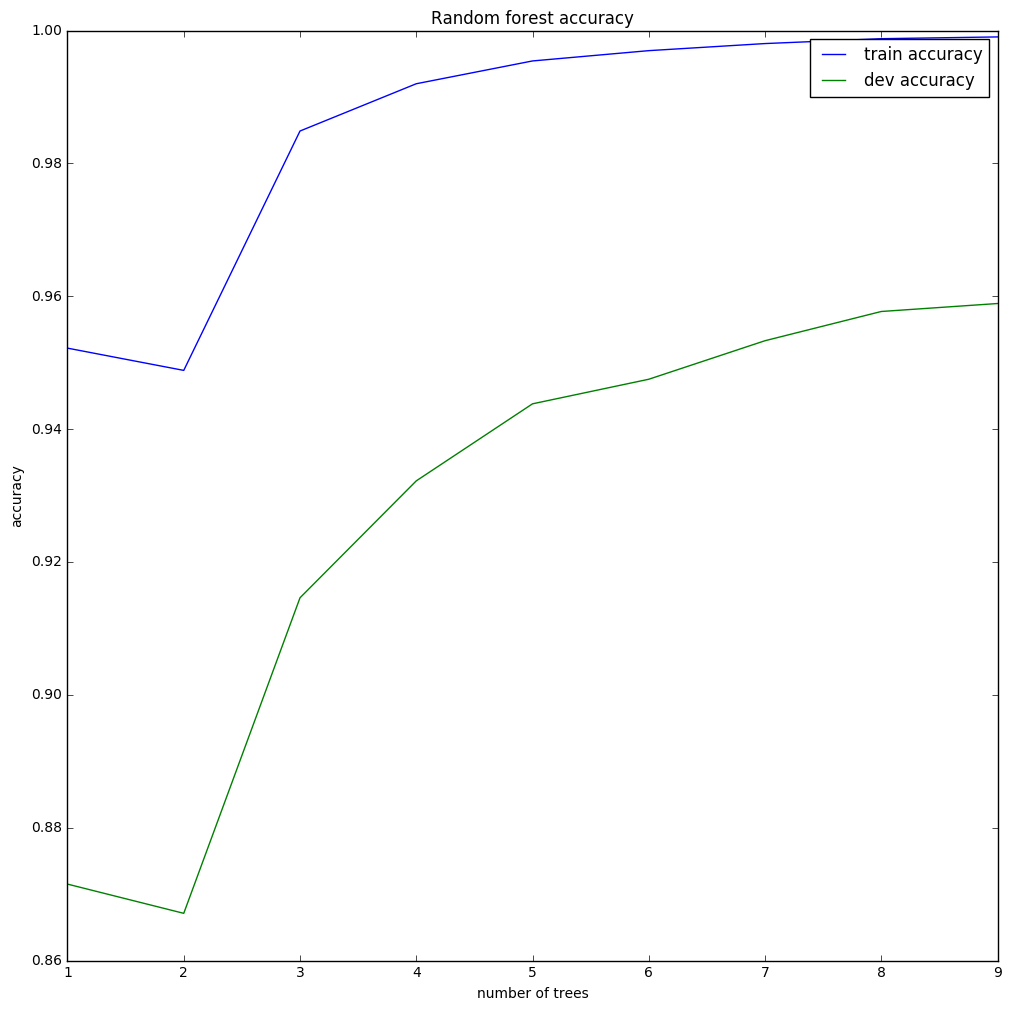

In [17]:
train_random_forest(range(1, 10))

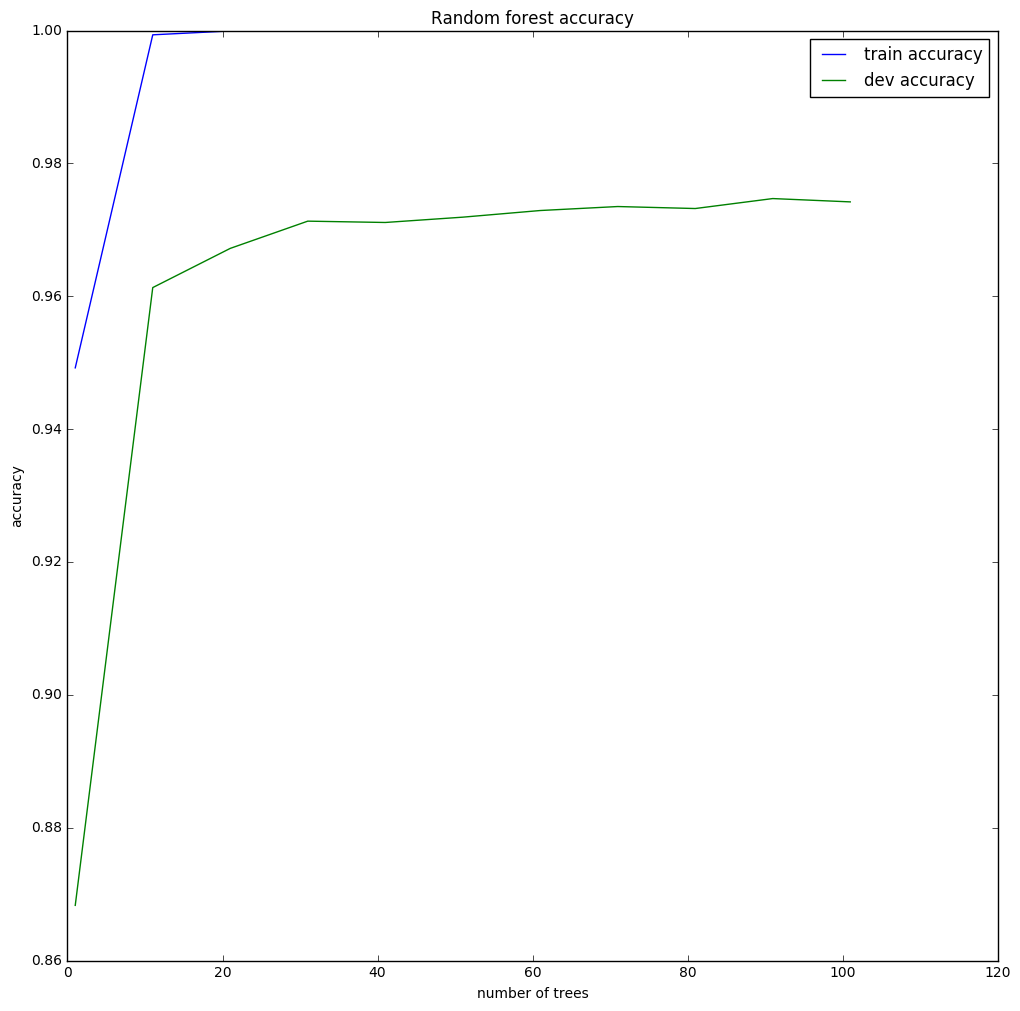

In [18]:
train_random_forest(range(1, 102, 10))

In [21]:
import sklearn.model_selection
from  sklearn.ensemble import RandomForestClassifier

tuned_parameters = [
    {
        'n_estimators': [10, 20, 50], 
        'min_samples_leaf': [2, 5, 10],
        'max_depth': [5, 10, 15]
    }
]

grid_search = sklearn.model_selection.GridSearchCV(
    RandomForestClassifier(),
    tuned_parameters,
    cv=5,
    n_jobs=32
)
grid_search.fit(x_train_small_deskew, y_train_small)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.827 (+/-0.034) for {'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 2}
0.849 (+/-0.030) for {'n_estimators': 20, 'max_depth': 5, 'min_samples_leaf': 2}
0.874 (+/-0.039) for {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 2}
0.820 (+/-0.077) for {'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 5}
0.850 (+/-0.037) for {'n_estimators': 20, 'max_depth': 5, 'min_samples_leaf': 5}
0.880 (+/-0.016) for {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 5}
0.788 (+/-0.034) for {'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 10}
0.849 (+/-0.018) for {'n_estimators': 20, 'max_depth': 5, 'min_samples_leaf': 10}
0.867 (+/-0.037) for {'n_estimators': 50, 'max_depth': 5, 'min_samples_leaf': 10}
0.851 (+/-0.037) for {'n_estimators': 10, 'max_depth': 10, 'min_samples_leaf': 2}
0.893 (+/-0.026) for {'n_estimators': 20, 'max_depth': 10, 'min_samples_leaf': 2}
0.905 (+/-0.028) for {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 2}
0.860 (+/-0.051) for {

In [40]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=2, max_depth=10)
rfc.fit(x_train_deskew, y_train)
print('Performance on train', rfc.score(x_train_deskew, y_train))
print('Performance on test', rfc.score(x_test_deskew, y_test))

('Performance on train', 0.97148333333333337)
('Performance on test', 0.95850000000000002)


## Ada Boost

In [29]:
import sklearn.model_selection
from  sklearn.ensemble import AdaBoostClassifier

tuned_parameters = [
    {
        'n_estimators': [10, 20, 50, 100, 200]
    }
]

grid_search = sklearn.model_selection.GridSearchCV(
    AdaBoostClassifier(),
    tuned_parameters,
    cv=5,
    n_jobs=32
)
grid_search.fit(x_train_small_deskew, y_train_small)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


0.513 (+/-0.133) for {'n_estimators': 10}
0.548 (+/-0.136) for {'n_estimators': 20}
0.569 (+/-0.129) for {'n_estimators': 50}
0.548 (+/-0.123) for {'n_estimators': 100}
0.561 (+/-0.132) for {'n_estimators': 200}


In [31]:
abc = AdaBoostClassifier(n_estimators=50)
abc.fit(x_train_deskew, y_train)
print('Performance on deskew train', abc.score(x_train_deskew, y_train))
print('Performance on deskew test', abc.score(x_test_deskew, y_test))

('Performance on deskew train', 0.80923333333333336)
('Performance on deskew test', 0.81100000000000005)


# Наивный байесовский классификатор

In [32]:
%%time
import sklearn.naive_bayes
naive_bayes_estimators = [
    sklearn.naive_bayes.BernoulliNB, 
    sklearn.naive_bayes.GaussianNB, 
    sklearn.naive_bayes.MultinomialNB
]
for estimator_class in naive_bayes_estimators:
    print("Using", estimator_class)
    estimator = estimator_class()
    estimator.fit(x_train_deskew, y_train)
    print("Train score {:.2f}".format(estimator.score(x_train_deskew, y_train)))
    print("Dev score {:.2f}".format(estimator.score(x_test_deskew, y_test)))

('Using', <class 'sklearn.naive_bayes.BernoulliNB'>)
Train score 0.86
Dev score 0.87
('Using', <class 'sklearn.naive_bayes.GaussianNB'>)
Train score 0.67
Dev score 0.67
('Using', <class 'sklearn.naive_bayes.MultinomialNB'>)
Train score 0.86
Dev score 0.86
Wall time: 10.4 s


Из всех алгоритмов, наилучшим образом показал себя SVM с полиномиальным ядром степени 2 (accuracy=98,6%)